## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [32]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [34]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
datagr = data.groupby('group').agg(x=('date', 'min'),y= ('date', 'max'))
display(datagr)

,x,y
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [38]:
datagr = data.groupby('group').agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
display(datagr)

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [39]:
intersect = set(data[data['group'] == 'A']['user_id']).intersection(set(data[data['group'] == 'B']['user_id']))
print(len(intersect))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [40]:
updated_data = data[data['user_id'].apply(lambda x: x not in intersect)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

![image.png](attachment:95f235d2-6323-4799-bf69-697fc57f727b.png)
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [44]:
updated_data.groupby('group').agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).rename(columns={'user_id':'count_visits', 'purchase': 'count_purchases', 'price':'sum_price'})

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

**Вывод**: Количество посещений в каждой из анализируемых групп сопоставимо (расхождение составляет менее 0.06%)

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [48]:
up_datagr = updated_data.groupby('group').agg({'user_id':'count', 'purchase':'sum', 'price':'sum'}).rename(columns={'user_id':'count_visits', 'purchase': 'count_purchases', 'price':'sum_price'})
up_datagr['conversion'] = up_datagr['count_purchases']/up_datagr['count_visits']*100
up_datagr['mean_check'] = up_datagr['sum_price']/up_datagr['count_purchases']
up_datagr

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

**Вывод**: В группе А конверсия больше на 0.14%, при этом значение среднего чека больше в группе В на более чем 7 тыс.руб.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [49]:
pivot = updated_data[updated_data['price'] > 0].pivot_table(
    index='group', 
    columns='price', 
    values='purchase', 
    aggfunc='sum')


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Тепловая карта покупательской способности туров в группах')

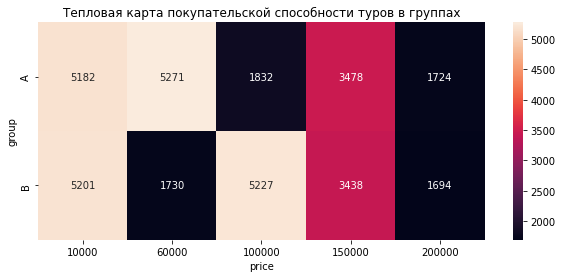

In [52]:
fig = plt.figure(figsize=(10, 4))
ax = sns.heatmap(pivot, annot=True, fmt = '.0f');
ax.set_title('Тепловая карта покупательской способности туров в группах')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

**Вывод**: Покупательская способность у группы А значимо выше группы В по турам стоимостью от 60 тыс.рублей и меньше. Туры стоимостью 100 тыс.рублей покупаются группой В гораздо чаще. Туры от 150 тыс.рублей покупаются примерно в равных количествах. 

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [53]:
daily_data = updated_data.groupby(['date', 'group']).agg({'user_id':'count','purchase':'sum','price': 'sum'}).reset_index().rename(columns={'user_id': 'count_visits','purchase': 'count_purchases','price': 'sum_price'})
daily_data['conversion'] = daily_data['count_purchases']/daily_data['count_visits'] * 100
daily_data['mean_check'] = daily_data['sum_price']/daily_data['count_purchases']
print('Конверсия')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'conversion']].round(2))
 
print('Средний чек')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-03')][['group', 'mean_check']].round())

Конверсия


,group,conversion
2,A,11.34
3,B,11.39


Средний чек


,group,mean_check
2,A,82888.0
3,B,87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [54]:
daily_data['cum_count_visits'] = daily_data.groupby('group')['count_visits'].cumsum()
daily_data['cum_count_purchases'] = daily_data.groupby('group')['count_purchases'].cumsum()
daily_data['cum_sum_price'] = daily_data.groupby('group')['sum_price'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_count_purchases']/daily_data['cum_count_visits'] * 100
daily_data['cum_mean_check'] = daily_data['cum_sum_price']/daily_data['cum_count_purchases']
 
print('Кумулятивная конверсия 20 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-20')][['group', 'cum_conversion']].round(2))
print('Кумулятивная конверсия 12 января 2020 года:')
display(daily_data[daily_data['date'] == pd.to_datetime('2021-01-12')][['group', 'cum_mean_check']].round())

Кумулятивная конверсия 20 января 2020 года:


,group,cum_conversion
36,A,11.98
37,B,11.90


Кумулятивная конверсия 12 января 2020 года:


,group,cum_mean_check
20,A,81492.0
21,B,88352.0


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

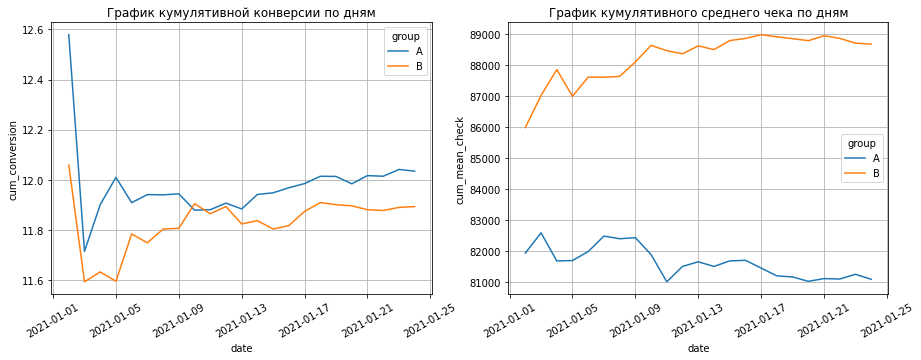

In [56]:
fig, axes= plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=axes[0])
sns.lineplot(x='date', y='cum_mean_check', data=daily_data, hue='group', ax=axes[1])
axes[0].set_title('График кумулятивной конверсии по дням')
axes[1].set_title('График кумулятивного среднего чека по дням')
axes[0].xaxis.set_tick_params(rotation = 30)
axes[1].xaxis.set_tick_params(rotation = 30)
axes[0].grid(True);
axes[1].grid(True);

**Вывод**: Исходя из поведения графиков к концу исследования метрики стабилизировались. Кумулятивная конверсия в группе А выше, но кумулятивный средний чек при этом больше в группе В

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [57]:
converted_piv= data.groupby('group')['purchase'].agg(['sum', 'count'])

H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А больше чем конверсия в группе B'
alpha = 0.05 
_, p_value = proportions_ztest(
    count=converted_piv['sum'],
    nobs=converted_piv['count'], 
    alternative='larger'
)
print('p-value: ', round(p_value, 2))
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.11
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

**Вывод**: Статистической разницы в конверсиях при заданном уровне значимости нет

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [59]:
def conversion_conf_interval(n, x_p, gamma=0.95):
  alpha = 1 - gamma
  z_crit = -norm.ppf(alpha/2)
  eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
  lower_bound = x_p - eps 
  upper_bound = x_p + eps 
  return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

a_data = updated_data[updated_data['group'] == 'A']
b_data = updated_data[updated_data['group'] == 'B']
conf_interval_a = conversion_conf_interval(
a_data['user_id'].count(),
a_data['purchase'].mean())
conf_interval_b = conversion_conf_interval(
b_data['user_id'].count(), 
b_data['purchase'].mean())
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

def diff_conversion_conf_interval(n, xp, gamma=0.95):
  alpha = 1 - gamma
  diff = xp[1] - xp[0] 
  z_crit = -norm.ppf(alpha/2) 
  eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 
  lower_bound = diff - eps 
  upper_bound = diff + eps 
  return round(lower_bound *100, 2), round(upper_bound * 100, 2)


n = [a_data['user_id'].count(), b_data['user_id'].count()]
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

diff_inverval = diff_conversion_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)
Доверительный интервал для разности конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

**Вывод**: Доверительные интервалы для групп А и В пересекаются. Доверительный интервал для разности конверсий имеет отрицательное значение с левого края и положительное значение с правого конца интервала. Поэтому статистической разницы между группами по исследуемым параметрам нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [60]:
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 
 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
shapiro_result_a = shapiro(daily_data_a['mean_check'])
shapiro_result_b = shapiro(daily_data_b['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [61]:
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'
alpha = 0.05 
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_b = daily_data[daily_data['group'] == 'B']
 
results = ttest_ind(
    daily_data_a['mean_check'],
    daily_data_b['mean_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

**Вывод**: По данной метрике наблюдается статистическая разница между группами А и В

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [62]:
def mean_check_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 
    alpha = 1 - gamma 
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std / n**0.5 
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps 
    return round(lower_bound), round(upper_bound)
 
a_daily_data = daily_data[daily_data['group'] == 'A']
b_daily_data = daily_data[daily_data['group'] == 'B']
 
params_a = {
    'n': a_daily_data['count_visits'].count(), 
    'x_mean': a_daily_data['mean_check'].mean(), 
    'x_std': a_daily_data['mean_check'].std() 
}
params_b = {
    'n': b_daily_data['count_visits'].count(),
    'x_mean': b_daily_data['mean_check'].mean(), 
    'x_std': b_daily_data['mean_check'].std() 
}
 
print('Доверительный интервал для среднего чека группы А: {}'.format(mean_check_conf_interval(**params_a))) 
print('Доверительный интервал для среднего чека группы B: {}'.format(mean_check_conf_interval(**params_b)))

Доверительный интервал для среднего чека группы А: (79630, 82308)
Доверительный интервал для среднего чека группы B: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

**Вывод**: Доверительные интервалы не пересекаются. Это может служить подтверждением, что между группами существует статистическая разница по метрике ежедневного среднего чека.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Вывод: Исходя из полученных результатов стат.анализа по двум метрикам можно заключить, что по метрике "Конверсия" стат.разницы между двумя дизайнами нет. Однако, если рассматривать метрику "Средний чек", то результат для заказчика лучше для нового дизайна.